In [51]:
import sklearn as sk
import numpy as np
import skbio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from sklearn import preprocessing
from sklearn.manifold import TSNE
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from skbio.stats.ordination import pcoa 
from skbio import DistanceMatrix
from sklearn.metrics import pairwise_distances

In [94]:
#Loading in the data
raw_data = pd.read_csv('../samp_comp_0624_marti/samp_comp_summed_0624.csv')
#raw_data = pd.read_csv('../samp_comp_0624_marti/samp_comp_assigned_0624.csv')

# Melt the raw_data dataframe
raw_data_long = raw_data.melt(id_vars=['Taxon', 'NCBI_ID', 'Rank'], var_name='Sample_ID', value_name='Count')

metadata = pd.read_csv('../old_parameters_MARTI_samp_comp_read_data/Phyloseq_data/Sample_table.csv')

# Merge the melted raw_data with seq_info on 'Sample_ID'
merged_data = pd.merge(raw_data_long, metadata, on='Sample_ID', how='left')

#Filter to one taxonomic rank
filtered_data = merged_data[(merged_data['Rank'] == 'genus') & (merged_data['Count'] > 0)] #for summarised
# filtered_data = merged_data[(merged_data['Count'] > 0)] #for assigned

filtered_data = filtered_data.replace(',','', regex=True)
filtered_data['NumReads'] = pd.to_numeric(filtered_data['NumReads'], errors='coerce')
filtered_data['N50Length'] = pd.to_numeric(filtered_data['N50Length'], errors='coerce')
filtered_data['Longest'] = pd.to_numeric(filtered_data['Longest'], errors='coerce')

#calculating normalised count
filtered_data['read_norm_by_total'] = filtered_data['Count'] / filtered_data['NumReads']


Adding cols to the metadata to use later

In [96]:
#Colour plot by location using metadata
location_colors = {'NHM': '#008080', 'Cfarm': '#FF7F50'} 

# Create a new column 'Color' in metadata DataFrame based on 'Location'
metadata['Colour'] = metadata['Location'].map(location_colors)

# Create a dictionary to map sampler labels to marker symbols
marker_data = {
    'Bobcat': 'o',  # circle marker
    'Cub': '+',     # Use '+' for plus marker
    'Sass': 'x',     # Use 'x' for x marker (doesn't quite match r aesthetics)
    'Micro': 's', # Use 's' for square marker
    'Compact': '^' # Use '^' for upward triangle marker
}

# Create a new column 'Marker' in metadata DataFrame based on 'Sampler'
metadata['Marker'] = metadata['Sampler'].map(marker_data)

## Creating a presence/absence matrix at Genus level

In [100]:
#Extracting the genus information
# creating a table of just Taxon & barcode
taxon_data = filtered_data[['Taxon', 'Sample_ID']]

#because this is a binary presence/absence matrix i only want unique taxa for each sample
#subset means we are dropping rows that have duplicate values in both sample & taxon cols
taxon_data = taxon_data.drop_duplicates(subset=['Sample_ID', 'Taxon'])

#Creating the matrix, for a t-SNE it's a case of presence or absence of each taxa
#Taxa as columns and Sample_ID and rows
#aggfunc - assigns a value of 1 to each cell in the binary matrix
#fill_value - any missing values in the matrix set to 0
binary_matrix = pd.pivot_table(taxon_data, index='Sample_ID', columns='Taxon', aggfunc=lambda x: 1, fill_value=0)

## T-SNE

In [67]:
# Perform T-SNE on your binary matrix---------------------------------
#n_components - data is reduced to 2 components for x and y
tsne = TSNE(n_components=2, random_state=0)
# #T-SNE co-ordinates are stored in t-sne_results
tsne_results = tsne.fit_transform(binary_matrix)

# Extract T-SNE coordinates for x and y axes
tsne_x = tsne_results[:, 0]
tsne_y = tsne_results[:, 1] 

Plot aesthetics

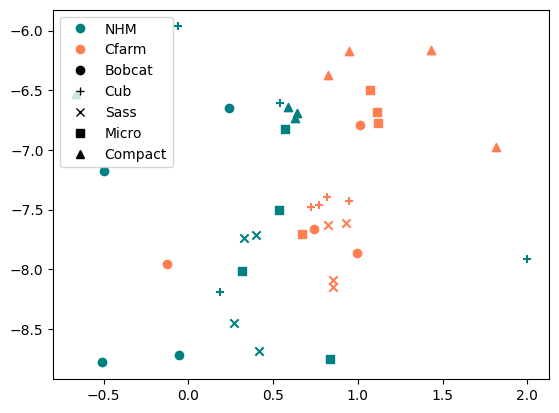

In [68]:
# Create proxy artists for the legend
location_lines = [mlines.Line2D([], [], color=color, marker='o', linestyle='None') for color in location_colors.values()]
sampler_lines = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in marker_data.values()]

# Create the legend
plt.legend(location_lines + sampler_lines, list(location_colors.keys()) + list(marker_data.keys()), loc='best')

# Plot the t-SNE results with color by location and marker by sampler
for i, barcode in enumerate(binary_matrix.index):
    # Get the color and marker for the current barcode from the metadata
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Marker'].values[0]
    
    plt.scatter(tsne_x[i], tsne_y[i], color=color, marker=marker)  # Use the color and marker while plotting

plt.savefig("../Images/Ordination/tsne_marti_assigned_0724.svg", format='svg')


## PCoA 

Jaccard and Bray Curtis - need to relaod the binary matrix code each time (above) for this to work 

In [101]:
# Keep a reference to the original index
original_index = binary_matrix.index

# Convert to numpy array
binary_matrix = np.array(binary_matrix)

# Calculate the dissimilarity matrix
dissimilarity_matrix = pairwise_distances(binary_matrix, metric='jaccard') #jaccard / braycurtis

# Perform PCoA on dissimilarity matrix
pcoa_results = pcoa(dissimilarity_matrix)

# Access the PCoA results
eigvals = pcoa_results.eigvals
samples = pcoa_results.samples

# Scale the samples for better visualization
scale_factor = 10
scaled_samples = samples * scale_factor

# Access the PCoA scores from the OrdinationResults object
pcoa_scores = pcoa_results.samples.values

/Users/berelsom/opt/anaconda3/envs/samp_comp/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/berelsom/opt/anaconda3/envs/samp_comp/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.002752884518595221 and the largest is 1.6061370770102148.
  warn(


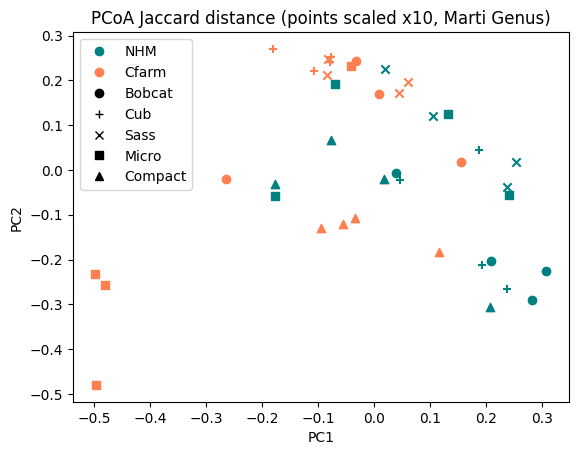

In [102]:
#Aesthetics

# Plot the PCoA results with color by location and marker by sampler
for i, barcode in enumerate(original_index):
    # Get the color and marker for the current barcode from the metadata
    color = metadata.loc[metadata['Sample_ID'] == barcode, 'Colour'].values[0]
    marker = metadata.loc[metadata['Sample_ID'] == barcode, 'Marker'].values[0]
    
    plt.scatter(pcoa_scores[i, 0], pcoa_scores[i, 1], color=color, marker=marker)  # Use the color and marker while plotting

# Create proxy artists for the legend
location_lines = [mlines.Line2D([], [], color=color, marker='o', linestyle='None') for color in location_colors.values()]
sampler_lines = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in marker_data.values()]

# Create the legend
plt.legend(location_lines + sampler_lines, list(location_colors.keys()) + list(marker_data.keys()), loc='best')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCoA Jaccard distance (points scaled x10, Marti Genus)")
plt.savefig("../Images/Ordination/pcoa_jaccard_marti_sum_genus_0724.svg", format='svg', dpi=300)

plt.show()